Example of using cppyy for bridgind C++ code to Python
===

The code below uses:
* [cppyy](https://cppyy.readthedocs.io/en/latest/index.html)
* [ctypes](https://docs.python.org/3/library/ctypes.html)
* [numpy](https://numpy.org/)
* [Pillow](https://pypi.org/project/Pillow/)
* [timeit](https://docs.python.org/3/library/timeit.html)

Note: in the first cell we import ROOT, then cppyy.  This is only necesary in an evironment like phys56xx where both packages are installed.  In an environment w/o ROOT, just import cppyy.  The code that follows is generic to using cppyy.

**CAVEAT**:  If I haven't mentioned it enough times, I'll do so again just in case... I do not recommend developing code in the notebook.  Notebooks are good for working with functions and classes in prebuit libraries and for prototyping things, but using them for writing larger amounts of code, expecially C/C++ will greatly slow down your develpment cycle.  Note that if you run the cppyy.cppdef insrtructions a second time, you'll get errors b/c C++ does not allow your to redefine classes or functions.  To change the compiled code you'll have to restart the kernel.  This is not very convenient, so I recommend making libraries and linking this in a shown below.

In [1]:
import ROOT as r  # not used, but we need to import this to use cppyy in our hybrid environment
import cppyy      # only this is needed if ROOT is not installed

Welcome to JupyROOT 6.28/04


We now have a just-in-time C++ compiler that is callable from Python.  It's cool, but don't over use it when you can build libraries instead for larger projects.

From the docs: *cppyy is based on Cling, the C++ interpreter, to match Python’s dynamism, interactivity, and run-time behavior*

Example 1: defining and compiling a C++ class 
---

In [2]:
cppyy.cppdef("""
class MyClass {
public:
    MyClass(int i) : m_data(i) {}
    virtual ~MyClass() {}
    virtual int add_int(int i) { return m_data + i; }
    int m_data;
};""")

True

In this case the interfaces to the C++ code are automatically defined.  There is no need to define argtypes/restype, so we can use our C++ class directly below.

In [3]:
from cppyy.gbl import MyClass
m = MyClass(42) # C++ class in Python!

We can even dynamically mix C++ and Python in various ways.  Below we add a new method to the class that is visible from the Python side.

In [4]:
cppyy.cppdef("""
void say_hello(MyClass* m) {
    std::cout << "Hello, the number is: " << m->m_data << std::endl;
}""")

True

In [5]:
MyClass.say_hello = cppyy.gbl.say_hello
m.say_hello()

Hello, the number is: 42


Example 2: defining a C++ function
----

In [6]:
cppyy.cppdef("""
// estimate pi from the dart throwing method
double findPi2(long nthrows=100*1000*1000){
  srand48((long)time(NULL));
  long count=0;
  for (int i=0; i<nthrows; ++i){
    double x=drand48();
    double y=drand48();
    if (x*x+y*y < 1) ++count;
  }
  return 4.0*count/nthrows;
}""")

True

In [7]:
%time PI=cppyy.gbl.findPi2(100*1000*1000)
print("Estimate for pi:",PI)

CPU times: user 1.21 s, sys: 7 ms, total: 1.22 s
Wall time: 1.21 s
Estimate for pi: 3.1413962


This is close to what we saw in the previous example. Next we'll look at an example of

Loading libraries with cppyy
---

In general it is very awkward developing C++ code as text string in the middel of a Python program.  It's fine to do this for short fucntions were you can achieve a quick speed boost.  But for substantial amounts of code you'll want compile you code into shared libraries.  You can test the code in the libraries by calling classes/functions from a dedicated C++ program or using a Python script.

The Makefile created a version of mylib with C++ style linkage, mylib.so.  We can load this via cppyy as shown below.  Notice that we inclulded the header file for the library.  cppyy uses this to automatically build our interfaces!!!  This is really great.  Using the recipie in the Makefile you can easily make (almost) any C++ code available in Python.

In [8]:
cppyy.include('mylib.h')
cppyy.load_library('mylib.so')
mandel=cppyy.gbl.mandel  # make a convenient handle to access our class

In [9]:
import numpy as np
# define parameters for the calulation
npX=2000   # 2000 x 2000 pixel image
npY=2000
nTrials=255
re1=-2.1
re2=0.6
im1=-1.5
im2=1.5
img=np.ndarray(shape=(npX,npY), dtype=np.double) # array to hold our image

In [10]:
%time mandel(img,re1,re2,im1,im2,npX,npY,nTrials)

CPU times: user 947 ms, sys: 15.9 ms, total: 963 ms
Wall time: 957 ms


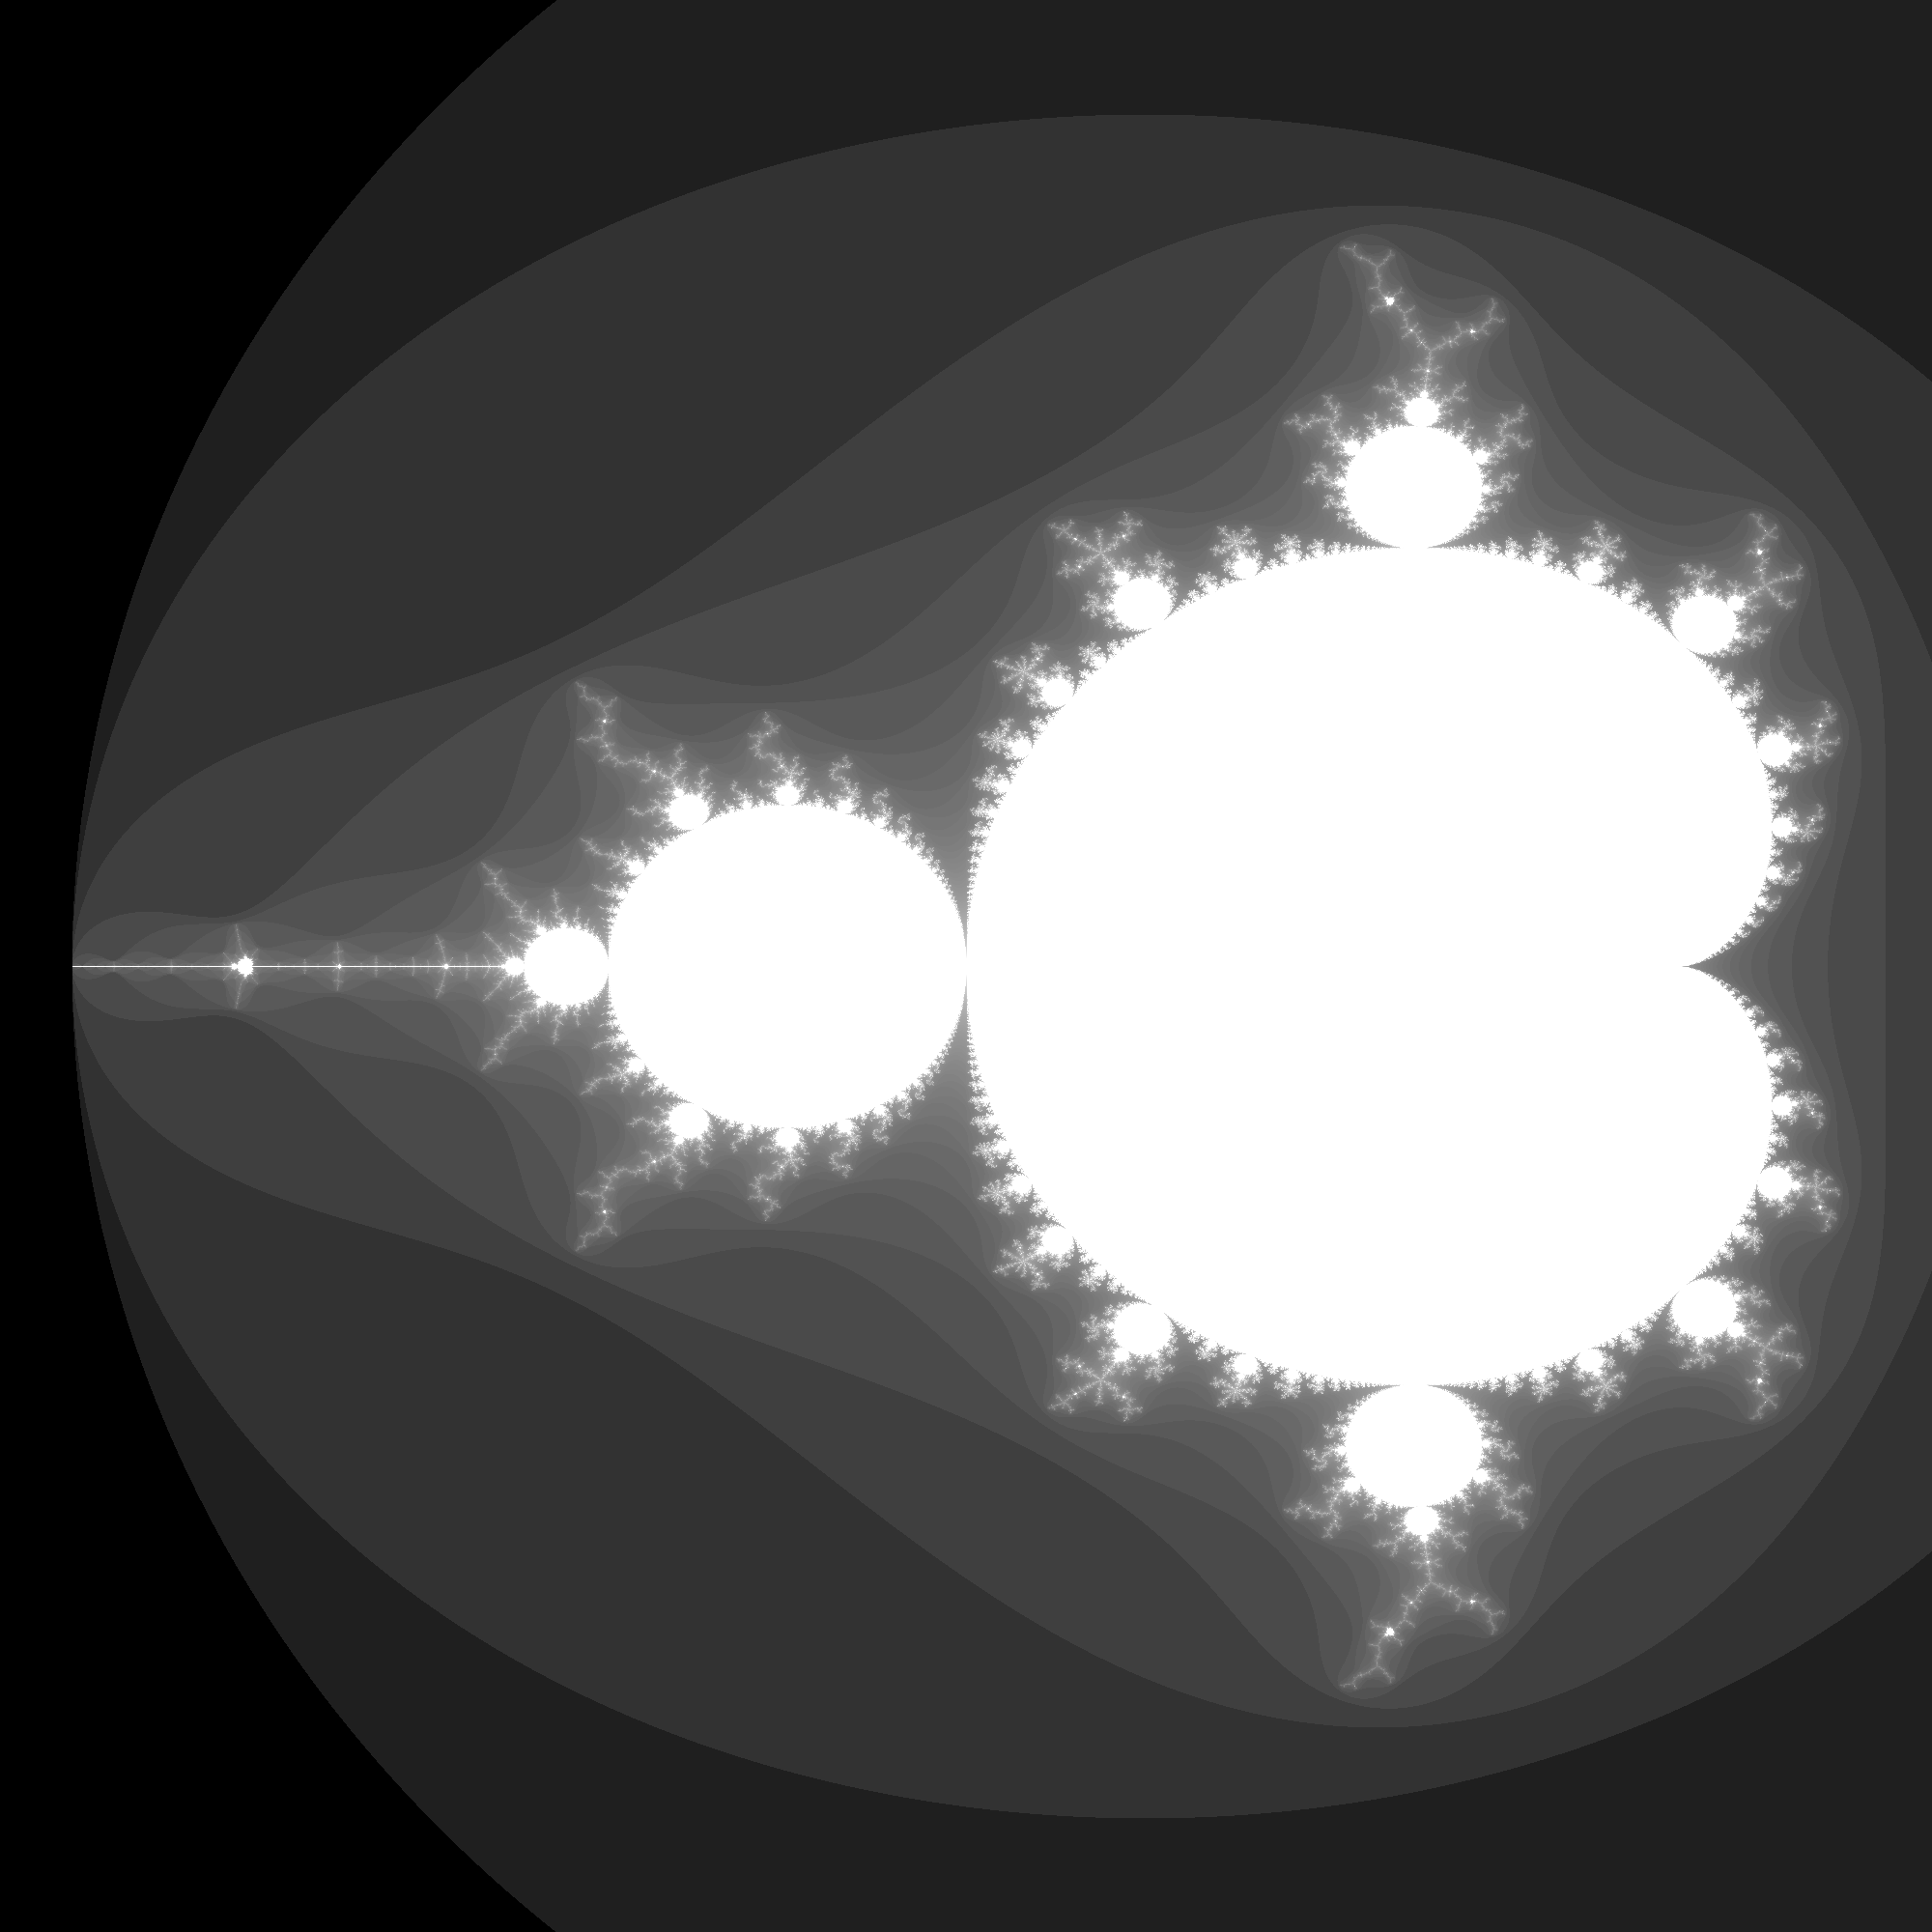

In [11]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

The amazing benefit of cppyy is that it can automatically build interfaces for a wide range of C++ objects including standard containers, like vectors.  It can be a little tricky to map containier in Python like numpy arrays or numerical arrays frin the Python array module to C++ counterparts, but it's usually possible to find useful examples in the cppyy documentation of by strategic web searching, consulting a friendly AI, etc.  If you are using ROOT objects, extensions to cppyy are provided to make the interface of C++ ROOT and Python objects a bit easier.

In the example below, we'll use a C++ class to perform the calculation above.  Refer to the code in mycpplib.cpp(h).

In [12]:
cppyy.include('mycpplib.h')
cppyy.load_library('mycpplib.so')
Mandel=cppyy.gbl.Mandel  # make a convenient handle to access our class

Let's see what we have here...

In [13]:
type(Mandel)

<class 'Mandel_meta'>

In [14]:
mymandel=Mandel()
from ctypes import c_double, c_int, POINTER
re1=c_double()
re2=c_double()
im1=c_double()
im2=c_double()
mymandel.getRange(re1,re2,im1,im2)  # look at the default range
print(f'range to explore: [{re1.value},{im1.value}] to [{re2.value},{im2.value}]')
nr=c_int()
ni=c_int()
mymandel.getResolution(nr,ni)
print(f'resolution: {nr.value}x{ni.value}')

range to explore: [-2.1,-1.5] to [0.6,1.5]
resolution: 2000x2000


In [15]:
mymandel.calculate()

In [16]:
import numpy as np
img=np.ndarray(shape=(nr.value,ni.value), dtype=np.double) # array to hold our image
mymandel.getImg(img.ctypes.data_as(POINTER(c_double)))

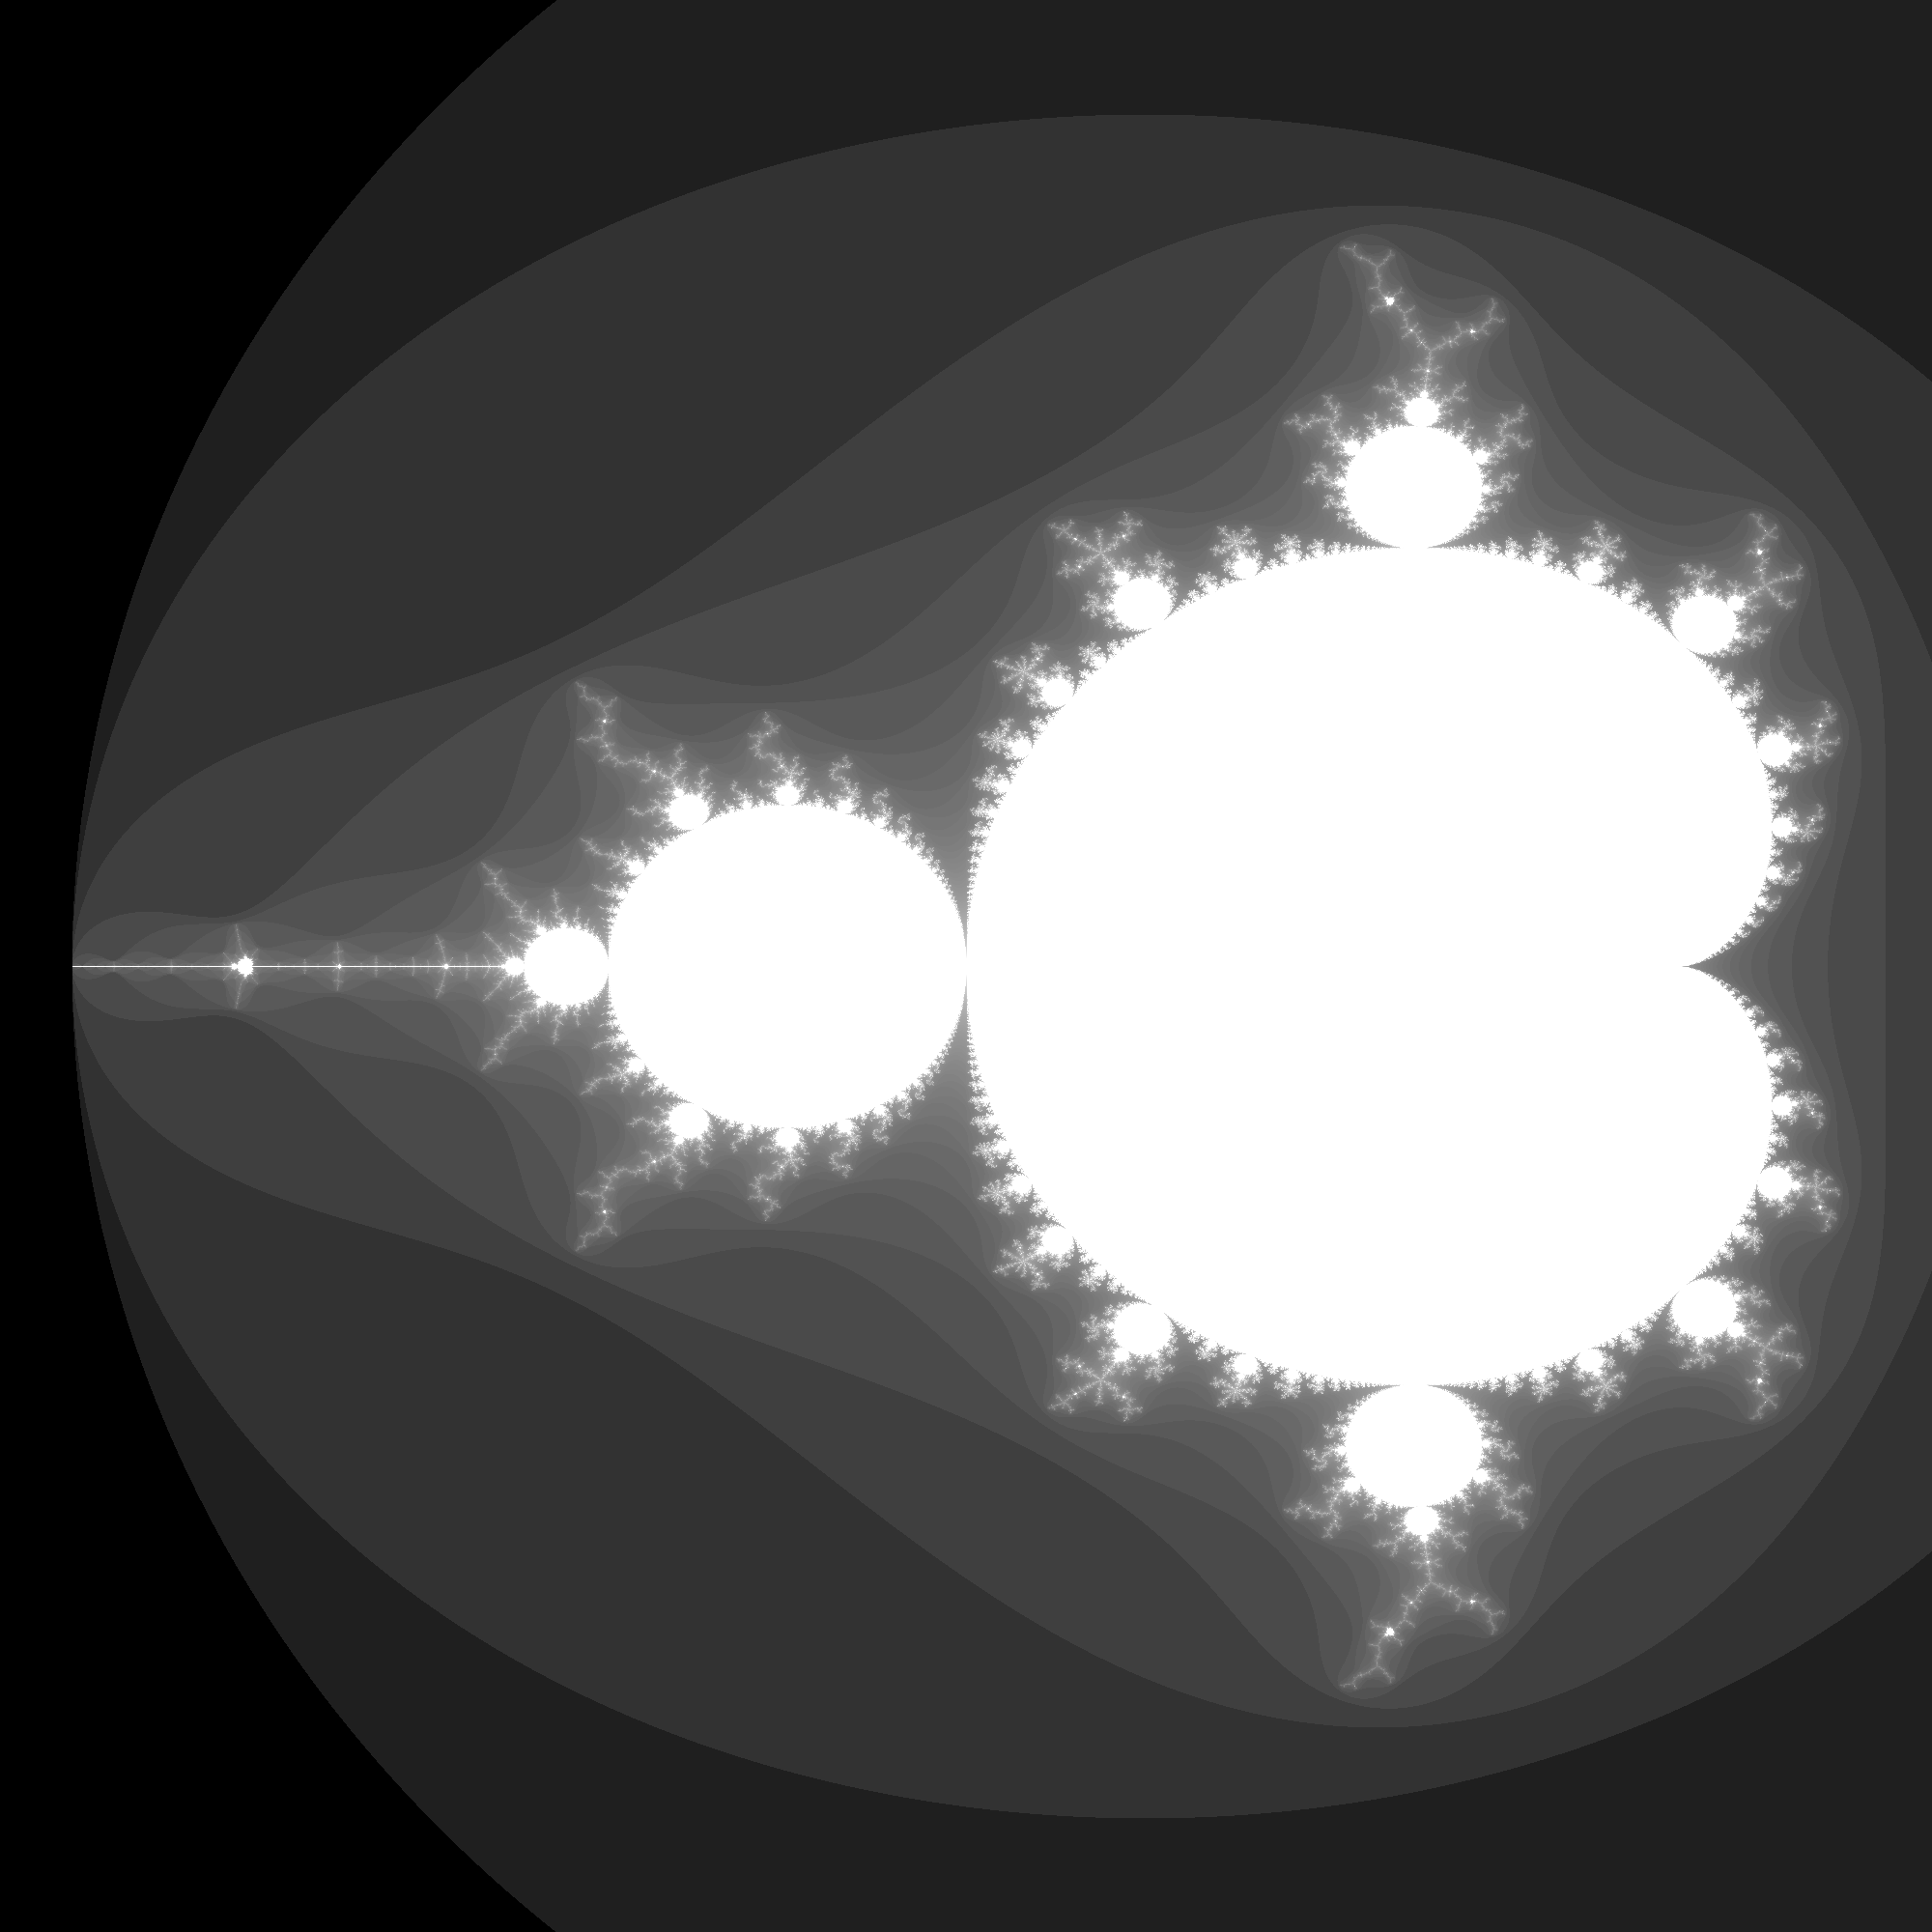

In [17]:
from PIL import Image

# convert values to 0 - 255 int8 format
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)

display(image)

In [18]:
mymandel.setRange(-.8,-.7,0,.2)  
mymandel.getRange(re1,re2,im1,im2)  # look at the default range
print(f'range to explore: [{re1.value},{im1.value}] to [{re2.value},{im2.value}]')

range to explore: [-0.8,0.0] to [-0.7,0.2]


Quiz for you:  Why do we have to recreate the img array below before retrieving the new scan? 

In [19]:
mymandel.calculate()
img=np.ndarray(shape=(nr.value,ni.value), dtype=np.double) # array to hold our image
mymandel.getImg(img.ctypes.data_as(POINTER(c_double)))

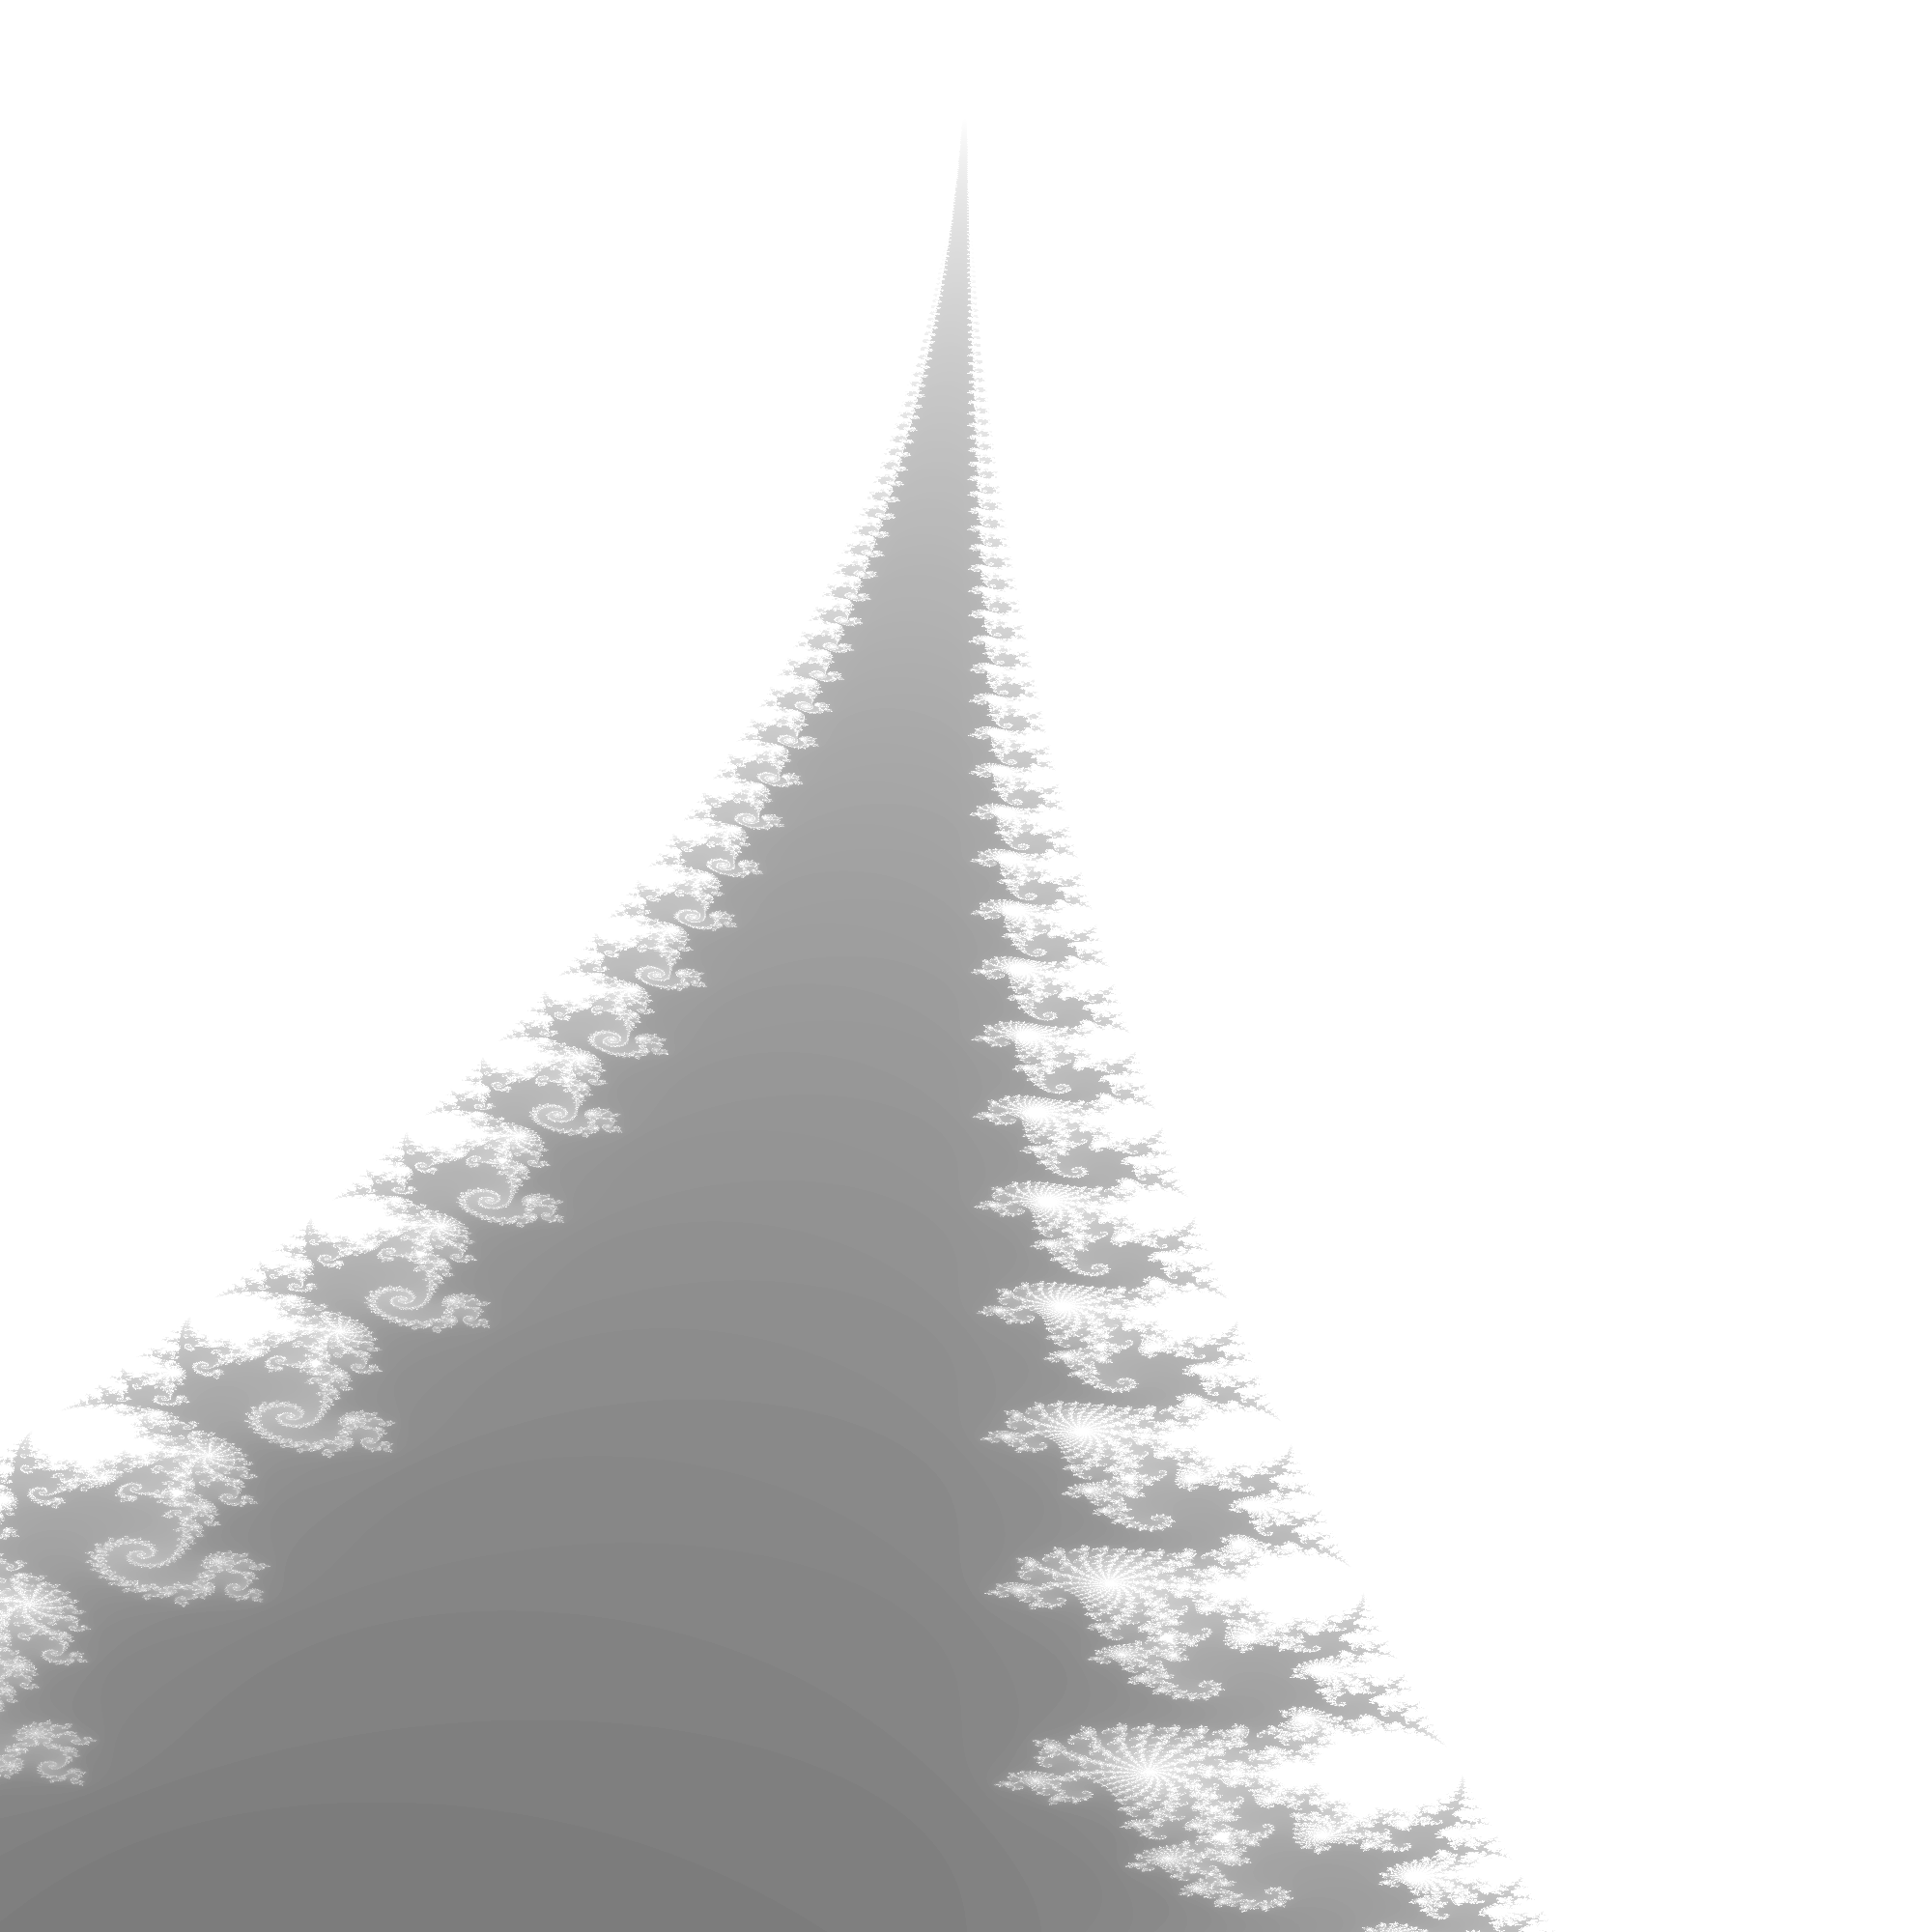

In [20]:
img=np.log(img)
img = (img/img.max()*255).astype('uint8')
image = Image.fromarray(img)
display(image)

Homework project
=================

**Work on this AFTER examining all of the examples presented in today's class**

Project 2
---------
Examine the Python code below.  Modify mycpplib to include a C++ version of this code.  Then produce a plot showing the ratio of the time required to perform the calculation in the two langiages versus the input number *n*.  Extend your plot to at least n=2500.

In [21]:
def count3d(n):
    count=0
    for i in range (n):
        for j in range (i+1,n):
            for k in range (j+1,n):
                count = count +1
    return count

Below we use the timeit module instead of the cell magick %time.  This allow us to retrieve the time in a Python variable.
Note: computer timers have limited accuracy, therefore you may observe large fraction fluctuations for small times.  The estimate can ebe improved by averaging over several callss to the code.  Be aware of this, but you don't need to be very accurate in measuring the small times for this project, the case for large *n* is the most interesting region!

In [22]:
#%time count3d(ncount)

ncount=10
import timeit
execTime=timeit.timeit(f'count3d({ncount})', number=1, globals=globals())
print(f'execution time = {execTime} seconds')

execution time = 8.496004738844931e-06 seconds


**Your code and plot goes here**